C:\Users\Alexandre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Tour 1: Length (with traffic) 240.49611485432536, Length (without traffic) 174.02653957346428, Route: [0, 29, 43, 30, 0]
Tour 2: Length (with traffic) 308.7171857359764, Length (without traffic) 217.76906707864566, Route: [0, 48, 5, 3, 7, 12, 20, 35, 0]
Tour 3: Length (with traffic) 270.439749779963, Length (without traffic) 191.3858276710505, Route: [0, 33, 18, 19, 0]
Tour 4: Length (with traffic) 251.6068426409825, Length (without traffic) 155.59614802749832, Route: [0, 21, 27, 0]
Tour 5: Length (with traffic) 59.15387467162965, Length (without traffic) 41.961334910575225, Route: [0, 45, 16, 0]
Tour 6: Length (with traffic) 313.88975379929843, Length (without traffic) 230.8679276123039, Route: [0, 41, 0]
Tour 7: Length (with traffic) 301.9699867491961, Length (without traffic) 199.19462726132792, Route: [0, 4, 26, 14, 32, 15, 31, 42, 0]
Tour 8: Length (with traffic) 397.2505201647988, Length (without traffic) 329.05773901495985, Route: [0, 8, 47, 24, 2, 22, 0]
Tour 9: Length (with tr

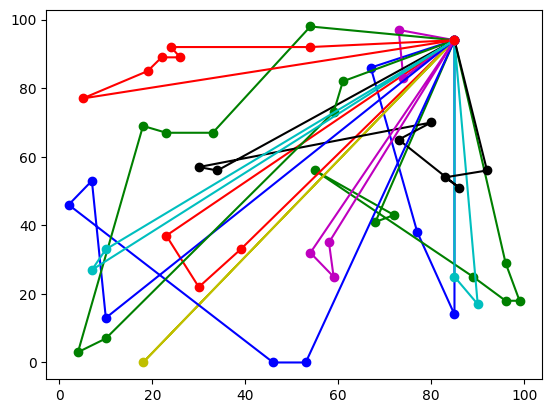

In [19]:
import numpy
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import psutil
import math
import time
from sklearn.cluster import KMeans

trucks = 2
city = 50


report_file = open("report.csv", "w")
traffic_matrix = np.random.rand(city, city)+1

def generate_truck_capacities(num_trucks, city):
    capacities = random.sample(range(1, 8), num_trucks)
    total_capacity = sum(capacities)

    while total_capacity < city-1:
        num_trucks += 1
        capacities.append(random.randint(1, 9))
        total_capacity = sum(capacities)

    return num_trucks, capacities

def read_dataset(filename):
    with open(filename) as fp:
        line = fp.readline()
        arr_city = []
        while line:
            xy = line.strip().split(";")
            xy = [float(e) for e in xy]
            # print(xy)
            arr_city.append(xy)
            line = fp.readline()

        return arr_city

def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / 1000000

def report(infos):
    report_file.write(infos + "\n")

def generate_cities(howmany=int(city), max_coordinates=100):
    return [random.sample(range(max_coordinates), 2) for _ in range(howmany)]

def generate_random_tour(cities):
    city_count = len(cities)
    return random.sample(range(city_count), city_count)

def split_tour(tour, num_trucks, cities, capacities):
    city_count = len(tour)

    city_coordinates = [cities[i] for i in tour]

    kmeans = KMeans(n_clusters=num_trucks, random_state=0).fit(city_coordinates)
    labels = kmeans.labels_

    sub_tours = [[] for _ in range(num_trucks)]
    truck_capacities = copy.deepcopy(capacities)

    for i, label in enumerate(labels):
        city = tour[i]
        sub_tour_capacity = truck_capacities[label]

        if sub_tour_capacity >= 1:
            sub_tours[label].append(city)
            truck_capacities[label] -= 1
        else:
            # If the truck has exceeded its capacity, look for another truck that can take over
            for j in range(num_trucks):
                if truck_capacities[j] >= 1:
                    sub_tours[j].append(city)
                    truck_capacities[j] -= 1
                    break

    for i in range(num_trucks):
        if sub_tours[i][0] != 0:
            sub_tours[i].insert(0, 0)
        if sub_tours[i][-1] != 0:
            sub_tours[i].append(0)

    return sub_tours

def distance(tour, cities, traffic_matrix):
    distance = 0
    for i in range(1, len(tour)):
        city1 = tour[i - 1]
        city2 = tour[i]
        distance += np.linalg.norm(np.array(cities[city1]) - np.array(cities[city2])) * traffic_matrix[city1][city2]
    distance += np.linalg.norm(np.array(cities[tour[-1]]) - np.array(cities[0])) * traffic_matrix[tour[-1]][0]
    return distance

def plot_tours(tours, cities):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, tour in enumerate(tours):
        tour_x = [cities[j][0] for j in tour]
        tour_y = [cities[j][1] for j in tour]
        plt.plot(tour_x, tour_y, colors[i % len(colors)] + 'o-')
    plt.plot(cities[0][0], cities[0][1], 'ro')  # depot in red
    plt.show()
    
def simulated_annealing(temp_init, cooling, temp_min):
    start_time = time.time()
    initial_temperature = temp_init
    cooling_rate = cooling
    nb_iterations = 0
    report("Iterations, Temperature, Best_Distance_Sans_Depot, current_distance, Time, Memory")

    cities = generate_cities()

    current_tour = generate_random_tour(cities)
    current_distance = distance(current_tour, cities, traffic_matrix)
    best_tour = current_tour
    best_distance = current_distance
    compteur = 2
    temperature = initial_temperature

    while temperature > temp_min:
        nb_iterations = nb_iterations + 1

        new_tour = copy.copy(current_tour)
        # Perform a random swap of two cities in the tour
        swap_indices = random.sample(range(1, len(new_tour)), 2)
        new_tour[swap_indices[0]], new_tour[swap_indices[1]] = new_tour[swap_indices[1]], new_tour[swap_indices[0]]

        new_distance = distance(new_tour, cities, traffic_matrix)
        delta_distance = new_distance - current_distance

        if delta_distance < 0 or random.random() < math.exp(-delta_distance / temperature):
            current_tour = new_tour
            current_distance = new_distance

        if current_distance < best_distance:
            best_tour = current_tour
            best_distance = current_distance
            # print(best_tour, best_distance)

        temperature *= cooling_rate
        if compteur > 0 and temperature < 0.001:
            temperature = 100
            compteur -= 1
        if nb_iterations % 200 == 0:
            time_to_write = time.time() - start_time
            report("{}, {}, {}, {}, {}, {}".format(nb_iterations, temperature, best_distance, current_distance, time_to_write,
                                                   print_memory_usage()))

    num_trucks, capacities = generate_truck_capacities(int(trucks), int(city))
    sub_tours = split_tour(best_tour, num_trucks, cities, capacities)

    total_distance_no_traffic = 0
    total_distance = 0
    
    for i, sub_tour in enumerate(sub_tours):
        sub_tour_distance = distance(sub_tour, cities, traffic_matrix)
        sub_tour_distance_no_traffic = distance(sub_tour, cities, np.ones((len(cities), len(cities))))
        print("Tour {}: Length (with traffic) {}, Length (without traffic) {}, Route: {}".format(
            i + 1, sub_tour_distance, sub_tour_distance_no_traffic, sub_tour))

        total_distance += sub_tour_distance
        total_distance_no_traffic += sub_tour_distance_no_traffic

    print("Total distance (with traffic): {}".format(total_distance))
    print("Total distance (without traffic): {}".format(total_distance_no_traffic))
    print("Execution time in seconds: ", time.time() - start_time)
    print("Memory used: ", print_memory_usage(), "MB")
    print("Number of iterations: {}".format(nb_iterations))
    print("Cities: ", city)
    print("Total trucks: ", num_trucks)
    print("Capacities: ", capacities)
    plot_tours(sub_tours, cities)

simulated_annealing(10000, 0.999, 0.0001)
